In [3]:
import os
from matplotlib.pyplot import imread
#some important defines for rest of project
celeb_height = 218
celeb_width = 178
celeb_depth = 3

# specifiy the CelebA folder
dirname = "./Data/img_align_celeba/img_align_celeba"

files = [filename for (dirpath, dirnames, filenames) in os.walk(dirname)
                  for filename in filenames if filename[-4:] == ".jpg"]

if len(files) == 0:
    print ("ERROR: wrong folder")
    import sys  
    sys.exit(1)
    
print('Total number of celebA images is : ', len(files))
print('First 10 files are:')
for i, filename in enumerate(files):
    if i < 10:
         print(filename)

Total number of celebA images is :  202599
First 10 files are:
000001.jpg
000002.jpg
000003.jpg
000004.jpg
000005.jpg
000006.jpg
000007.jpg
000008.jpg
000009.jpg
000010.jpg


# Look at some test images

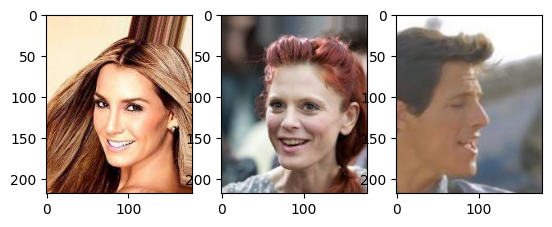

In [4]:
# tns = torch.tensor([1.,0,1])
# U, S, V = torch.pca_lowrank(tns,q=None, center=True, niter=2)
from skimage import io
import matplotlib.pyplot as plt

face1 = io.imread(dirname+"/"+files[0])
face2 = io.imread(dirname+"/"+files[1])
face3 = io.imread(dirname+"/"+files[2])

plt.subplot(1, 3, 1)
plt.imshow(face1)
plt.subplot(1, 3, 2)
plt.imshow(face2)
plt.subplot(1, 3, 3)
plt.imshow(face3)

# Step 1: Read in Image Data as Tensor
The numpy array is great, but we would prefer to user tensors. Note we need the dtype of the tensor to be a float so we can support the later operations, but to save space on the operation of reading the imgaes in, we only use a uint8.Also, the grayscale version of each image tends to yield better results


In [356]:
import torch 
import imageio.v3 as iio
import numpy as np
total_number_of_faces = 100

dimx, dimy = int(218), int(178)

def rgb2gray(image):
    img_gray = np.zeros((218, 178, 3), dtype = np.uint8)
    for i in range(218):
        for j in range(178):
            img_gray[i,j] = (1/3)*image[i,j,0] + (1/3)*image[i,j,1] + (1/3)*image[i,j,2]
    return img_gray

tensor_data = torch.zeros(total_number_of_faces, dimx*dimy*3, dtype=torch.uint8)

for index, filename in enumerate(files):
    if index == total_number_of_faces:
        break
    tensor_data[index] = torch.tensor(((rgb2gray(iio.imread(dirname+"/"+filename)).flatten().ravel())))

The shape of each element is 217\*178\*3, the full size of each image.
The shape of data is a 2D array with the first number indicating the number of pictures and the second the size of each (in the collapsed form above)

In [357]:
print("single image tensor:", tensor_data[0].shape)
print("image data tensor:", tensor_data.shape)



single image tensor: torch.Size([116412])
image data tensor: torch.Size([100, 116412])


In [358]:
tensor_data

tensor([[225, 225, 225,  ...,  64,  64,  64],
        [ 54,  54,  54,  ..., 123, 123, 123],
        [255, 255, 255,  ...,  94,  94,  94],
        ...,
        [138, 138, 138,  ..., 207, 207, 207],
        [122, 122, 122,  ...,  36,  36,  36],
        [ 56,  56,  56,  ...,  34,  34,  34]], dtype=torch.uint8)

# Step 2: Preprocess Data
Now we want to perform Principal Componant Analysis on the data. This helps with centering and to pull out the principal componants

In [359]:
U,S,V = torch.pca_lowrank(tensor_data.double(), q=total_number_of_faces, center=True, niter=3)

print("U:", U.shape)
print("S:", S.shape)
print("V:", V.shape)

# torch.matmul(U, U.T)
# torch.matmul(V.T, V)

U: torch.Size([100, 100])
S: torch.Size([100])
V: torch.Size([116412, 100])


 The relation of (U, S, V) to PCA is as follows:

A is a data matrix with m samples and n features

the V columns represent the principal directions

S ** 2 / (m - 1) contains the eigenvalues of A.T * A / (m - 1)
which is the covariance of A when center=True is provided.

matmul(A, V[:, :k]) projects data to the first k principal components

In [360]:
k = 10000 #200000
preprocessed_data_temp = torch.matmul(tensor_data.double().T, V.T[:, :k])

preprocessed_data_temp.shape

torch.Size([116412, 10000])

We can reproduce the image by projecting the PCA result back into its original dimensions. We need to also convert the data back into integer form.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


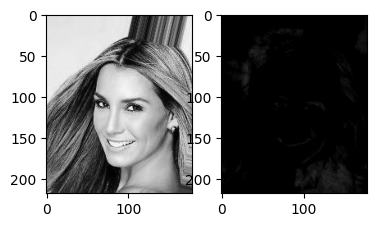

In [361]:
preprocessed_data  = torch.matmul(V.T[:, :k], preprocessed_data_temp.T).int()


preprocessed_data.shape

plt.subplot(1, 3, 1)
plt.imshow(tensor_data[0].reshape(celeb_height,celeb_width,celeb_depth))
plt.subplot(1, 3, 2)
plt.imshow(preprocessed_data[0].reshape(celeb_height,celeb_width,celeb_depth))

# Step 3: Compute Average Face Vector
Now the data is preprocessed, we follow the steps to compute the Eigan faces. First we need to compute the average face.

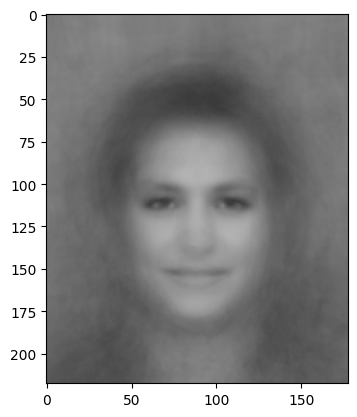

In [362]:
import pandas as pd

face_loader = torch.utils.data.DataLoader(tensor_data, batch_size=10000, shuffle=False)

mean_face = torch.zeros(celeb_height*celeb_width*celeb_depth, dtype=torch.float32)

for faces in face_loader:   
        faces = faces.type(torch.float32)
        mean_face += (faces.sum(0)) / (1.0 * total_number_of_faces)

plt.imshow((mean_face.type(torch.uint8)).reshape(218, 178, 3))

# Step 4: Subtract the mean face

torch.Size([100, 116412])

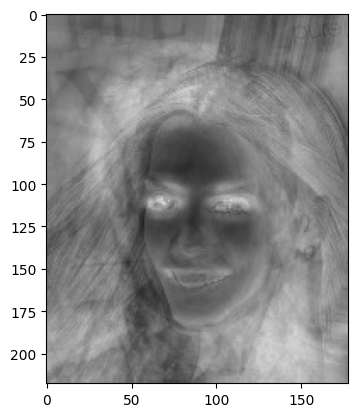

In [489]:
mean_face_removed = torch.zeros(total_number_of_faces, dimx*dimy*3, dtype=torch.uint8)

# preprocessed_data.shape
mean_face.shape
for index, filename in enumerate(files):
    if index == total_number_of_faces:
        break
    mean_face_removed[index] = torch.subtract(preprocessed_data[index], mean_face, alpha=1)

plt.imshow((mean_face_removed[0].type(torch.uint8)).reshape(218, 178, 3))
mean_face_removed.shape

# Step 5: Compute the Covariance Matrix
We'll actually use a shortcut, but this is simple to compute so I added here

In [497]:
cov_data = torch.cov(mean_face_removed, correction=1)

cov_data

tensor([[988.7212,  92.0688, 513.2250,  ..., 499.2032, 496.5354, 410.9946],
        [ 92.0688, 809.1910, 503.3154,  ..., 459.1139, 464.7579, 560.4152],
        [513.2250, 503.3154, 550.6472,  ..., 506.5231, 494.9667, 504.8771],
        ...,
        [499.2032, 459.1139, 506.5230,  ..., 481.4938, 473.3274, 472.5581],
        [496.5355, 464.7579, 494.9666,  ..., 473.3274, 478.9054, 479.2080],
        [410.9946, 560.4153, 504.8771,  ..., 472.5581, 479.2080, 536.1447]])

# Step 6: Compute the Eigen Vectors


In [502]:
# automatically normalizes to 1
# eigen_vec, eigen_val = torch.linalg.eig(cov_data)
small_cov =torch.matmul(mean_face_removed.double(), mean_face_removed.double().T)

eigen_vec, eigen_val = torch.linalg.eig(small_cov)

eigen_val

tensor([[-0.0843+0.j, -0.2325+0.j, -0.3186+0.j,  ...,  0.0116+0.j,  0.0505+0.j,
          0.0051+0.j],
        [-0.1068+0.j,  0.1650+0.j,  0.2615+0.j,  ...,  0.0434+0.j, -0.0777+0.j,
         -0.0141+0.j],
        [-0.0989+0.j, -0.0745+0.j,  0.0194+0.j,  ..., -0.1203+0.j,  0.0562+0.j,
         -0.0433+0.j],
        ...,
        [-0.0995+0.j, -0.0474+0.j, -0.0284+0.j,  ...,  0.0676+0.j, -0.1837+0.j,
          0.1608+0.j],
        [-0.0985+0.j, -0.0164+0.j, -0.0234+0.j,  ..., -0.0387+0.j, -0.0362+0.j,
          0.0708+0.j],
        [-0.1013+0.j,  0.0420+0.j,  0.0511+0.j,  ...,  0.0061+0.j, -0.0058+0.j,
          0.0064+0.j]], dtype=torch.complex128)

# Step 7: Keep only the Best K Vectors

In [521]:
#number of k -largest to keep
import numpy as np

#for complex nubmer compairison
np_eigan_vals = np.array(eigen_val)
np_eigan_vals_abs = np.zeros(len(np_eigan_vals))

np.absolute(np_eigan_vals[0])
# for i in range(len(np_eigan_vals)):
#     np_eigan_vals_abs[i] = np.absolute(np_eigan_vals[i])[0]

# np_eigan_vals_abs
# ind = np.argpartition(np_eigan_vals, -4)[-4:]
# ind

# best_vectors = eigen_vec.real.int()
# # np_vectors
# # print("before realized", eigen_vec)
# # print("after realized", best_vectors)
# # best_vectors = torch.tensor(np_vectors)

# np_eigan_vals
# best_vectors
# np_vectors
# best_vectors

array([8.42803629e-02, 2.32519269e-01, 3.18639493e-01, 3.29130407e-01,
       3.32678216e-02, 7.82800483e-03, 9.78588009e-03, 4.83208177e-02,
       7.50206311e-03, 7.48373936e-02, 1.63489768e-01, 4.03177252e-02,
       1.85456801e-02, 5.88926608e-02, 8.61195028e-02, 3.56641507e-02,
       5.94018710e-02, 4.57387133e-02, 8.87233129e-02, 7.28832596e-02,
       2.63275195e-02, 1.96175150e-02, 6.23113904e-02, 3.76791071e-02,
       4.42998637e-02, 3.58611299e-04, 1.71985602e-02, 5.75350589e-02,
       6.62520680e-02, 1.43416296e-02, 2.14195495e-02, 3.52485374e-02,
       2.13745544e-02, 5.92607282e-02, 5.74159812e-02, 1.07813056e-02,
       2.03576849e-02, 1.29716781e-02, 6.58923471e-02, 4.31599064e-02,
       3.14296474e-02, 1.34603349e-02, 1.63333584e-02, 5.79467812e-03,
       1.43521595e-02, 1.12581712e-01, 5.19093037e-02, 1.37965255e-01,
       1.15943203e-02, 1.20539884e-01, 1.89588870e-01, 5.93042993e-02,
       2.25811765e-02, 1.93351121e-01, 3.15317091e-02, 8.97614458e-02,
      

# Step 8: Use the eigen vectors to contruct eigen faces

Each face (minus the mean) can be contructed from the eigen vectores calculated earlier. Only a few are shown here

tensor(393440301, dtype=torch.int32)
tensor([0, 0, 0,  ..., 0, 0, 0], dtype=torch.uint8)
tensor([0, 0, 0,  ..., 0, 0, 0], dtype=torch.uint8)
tensor([0, 0, 0,  ..., 0, 0, 0], dtype=torch.uint8)


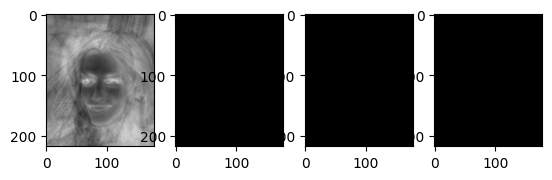

In [507]:
torch.real(best_vectors)

plt.subplot(1, 4, 1)
plt.imshow((mean_face_removed[0].type(torch.uint8)).reshape(218, 178, 3))

print(best_vectors.real.int()[1])

# best_vectors.real[0] works
eig_face1 = torch.mul(mean_face_removed[0], best_vectors.real.int()[0])
eig_face2 = torch.mul(mean_face_removed[0], best_vectors.real.int()[0])
eig_face3 = torch.mul(mean_face_removed[0], best_vectors.real.int()[0])
eig_face4 = torch.mul(mean_face_removed[0], best_vectors.real.int()[0])

eig_face_sum = faces.type(torch.uint8)
eig_face_sum =  eig_face1 + eig_face2

print(eig_face1)
print(eig_face2)
print(eig_face_sum)

plt.subplot(1, 4, 2)
plt.imshow((eig_face1.type(torch.uint8)).reshape(218, 178, 3))
plt.subplot(1, 4, 3)
plt.imshow((eig_face2.type(torch.uint8)).reshape(218, 178, 3))
plt.subplot(1, 4, 4)
plt.imshow((eig_face_sum.type(torch.uint8)).reshape(218, 178, 3))